# Implementación de modelos de ensambles, balanceo de clases y feature importance

Creación de documento: 3 de mayo de 2022


<u>***Información sobre los datasets***</u>:

- dataux: un dataset a elección que trasciende las secciones. *Sacramentorealestatetransactions.csv* es un dataset de bienes raíces. O *customer_transaction_data* dataset de la clase 11.
- data: dataset propuesto por los distintos desafíos en el contenido de Digital House

<u>***Propuesta de trabajo***</u>:

- Crear una notebook cuyo código desarrollado esté descripto a través de logging y cuya evolución en su proceso quede debidamente registrado en GitHub
- Las librerías estandar se importan al comienzo del código, mientras que las específicas a cada modelo se hará de forma previa a ser implementadas

<u>***Propuesta de trabajo***</u>:


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics as metrics

import os
import logging

path = os.getcwd()
print (path)

x = 'x'
formatter = f'{x+x}) %(levelname)s | %(message)s'#| line %(lineno)d
logging.basicConfig(filename='logfile.log', level=logging.INFO, force=True, filemode='w', **{'format':formatter})
logger = logging.getLogger()

C:\Users\aguST\dh\Clases\C44-TP_FINAL


In [2]:
logger.info('Se carga dataux')

In [3]:
# Cargar y visualizar dataset
dataux = pd.read_csv('Sacramentorealestatetransactions.csv')
print ('Todos los registros perteneces al mismo "state": California')
dataux.drop('state', axis=1, inplace=True)
columnas = ['calle', 'ciudad', 'cod_postal', 'dormitorios', 'bagnos', 'sup_ft2', 'tipo', 'fecha_venta', 'precio', 'lat', 'lon']
dataux.columns = columnas
display (dataux)
print (dataux.shape)

# Eliminación de outlier
dataux.drop(dataux[dataux.tipo == 'Unkown'].index, inplace=True)

Todos los registros perteneces al mismo "state": California


,calle,ciudad,cod_postal,dormitorios,bagnos,sup_ft2,tipo,fecha_venta,precio,lat,lon
0,3526 HIGH ST,SACRAMENTO,95838,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768
...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,4,3,2280,Residential,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620
981,6932 RUSKUT WAY,SACRAMENTO,95823,3,2,1477,Residential,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890
982,7933 DAFFODIL WAY,CITRUS HEIGHTS,95610,3,2,1216,Residential,Thu May 15 00:00:00 EDT 2008,235000,38.708824,-121.256803
983,8304 RED FOX WAY,ELK GROVE,95758,4,2,1685,Residential,Thu May 15 00:00:00 EDT 2008,235301,38.417000,-121.397424


(985, 11)


In [4]:
# Primera clase 
dataux['tipo'].value_counts()

Residential     917
Condo            54
Multi-Family     13
Name: tipo, dtype: int64

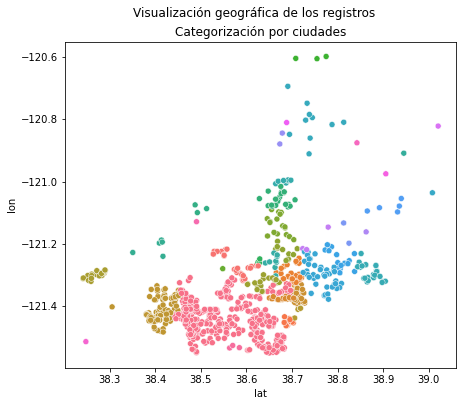

In [5]:
# Visualización 1
plt.figure(figsize=(7,6))
sns.scatterplot(data=dataux, x='lat', y='lon', hue='ciudad', legend=False).set(title='Categorización por ciudades')
plt.suptitle('Visualización geográfica de los registros', y=0.96);

In [6]:
logger.warning('Se crea la funcion: from_sq_ft_to_m2')

In [7]:
def from_sq_ft_to_m2(serie):
    """
    divide el valor de Área entre 10.764
    """
    return serie/10.764

In [8]:
dataux['sup_m2'] = from_sq_ft_to_m2(dataux.sup_ft2)
dataux.drop('sup_ft2', axis=1, inplace=True)
columnas[5] = 'sup_m2'
dataux = dataux.reindex(columnas, axis=1)

In [9]:
dataux.dtypes
pd.to_datetime(dataux.fecha_venta).value_counts()

C:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


2008-05-19    268
2008-05-16    263
2008-05-20    177
2008-05-21    158
2008-05-15    118
Name: fecha_venta, dtype: int64

In [10]:
dataux.fecha_venta

0      Wed May 21 00:00:00 EDT 2008
1      Wed May 21 00:00:00 EDT 2008
2      Wed May 21 00:00:00 EDT 2008
3      Wed May 21 00:00:00 EDT 2008
4      Wed May 21 00:00:00 EDT 2008
                   ...             
980    Thu May 15 00:00:00 EDT 2008
981    Thu May 15 00:00:00 EDT 2008
982    Thu May 15 00:00:00 EDT 2008
983    Thu May 15 00:00:00 EDT 2008
984    Thu May 15 00:00:00 EDT 2008
Name: fecha_venta, Length: 984, dtype: object

In [11]:
logger.critical('Celda 11: No encuentro mucho valor en este dataset')

-----------
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<u>**INTENTO 2**</u>

---------

In [12]:
logger.info('Se carga dataux')

In [13]:
dataux = pd.read_csv('customer_transaction_data.csv')
dataux

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0
...,...,...,...,...,...,...,...
1324561,2013-06-30,1129,2777,1,284.60,-71.24,0.0
1324562,2013-06-30,1129,2953,4,42.74,-28.50,0.0
1324563,2013-06-30,1129,2971,6,64.12,-42.74,0.0
1324564,2013-06-30,1129,46984,1,95.82,0.00,0.0


In [14]:
logger.error('Descarga visualizacion: histo_1.png, requiere trabajo exploratorio y explicativo, por cuestiones de procesamiento se debe comentar la línea')

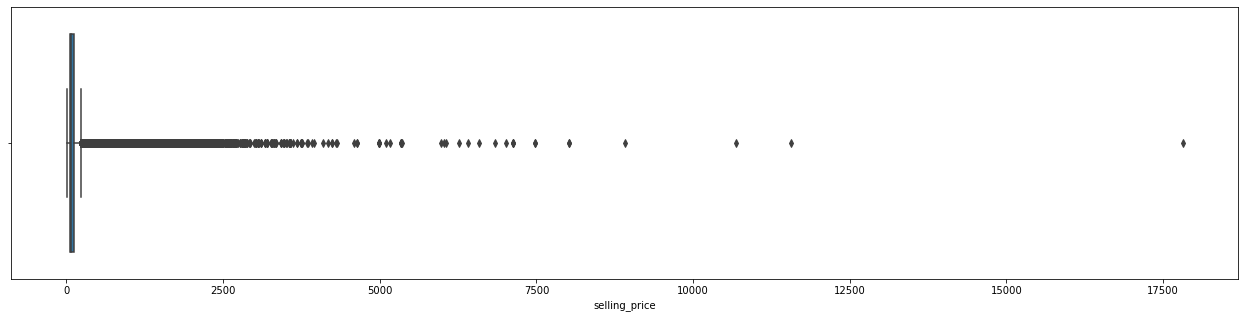

In [15]:
# EXPLORACION_1
dataux.customer_id.value_counts()# Existen 1582 clientes distintos que podemos categorizar
dataux.item_id.value_counts()# Existen 74063 items en venta
##dataux.quantity.plot.hist(xlim=(0,10), bins=50000)# hay ventas hasta por 80.000 unidades-la parte visible es hasta 20.000-hay una abrupta diferencia a partir de 10.000-hay una abrupta diferencia a partir de 1000- hay una abrupta diferencia a partir de 100-hay una abrupta diferencia a partir de 10
plt.figure(figsize=(22,5))
sns.boxplot(x=dataux.selling_price)#.set(xlim=(-10,2000)) ## el50% de las ventas están entre 0 y 250, trabajar escalas y valores sobre los ejes

"""
'other discount' y 'coupon_discount' se saltea la exploración
""";

----------------------

In [16]:
logger.info('Arranca toma de apuntes de las notebooks de clase')

In [17]:
print ('CLASE_36_Ensemble')

"""
Notebook: checkpoint
==========================================================================================================================
*Ejercicio 7

Escribir una funcion "predict_assemble" que calcule el valor de la etiqueta como la moda de las respuestas de los predictores base
Evaluar la performance del ensamble mediante "accuracy", "matriz de confusion"

Ejercicio 8

¿Cómo es la performance del modelo de ensamble respecto de la obtenida en los modelos base?
¿Mejora usando dos modelos en el ensable? ¿que modelos usarían?
==========================================================================================================================


Notebook: desafío
==========================================================================================================================
Ejercicio 4

Entrenar un modelo Naive Bayes y evaluar su performance en test mediante AUC. (Hay un sklearn.graph que vimos con Fer en la clase no me acuerdo)

Ejercicio 5

Entrenar un modelo KNN y evaluar su performance en test mediante AUC.

Ejercicio 6

Entrenar un arbol de clasificación y evaluar su performance mediante la matriz de confusion

*Ejercicio 7

Construir un modelo de ensamble usando como modelos base los 3 modelos anteriores
Escribir una funcion "predit_proba_assemble" que calcule la probabilidad de 1 como el promedio de las probabilidades respuesta de los predictores base
Evaluar la performance del ensamble (usando umbral 0.5) mediante: AUC, accuracy, matriz de confusion
Comparar los resultados obtenidos con el ejercicio 7 del checkpoint.

Opcional

¿Pueden mejorar el valor de accuracy del ensamble usando otro valor (distinto a 0.5) para el umbral?
¿Qué pasa con la matriz de confusion cuando mejora el valor de accuracy?
Pueden hacer un ciclo for con distintos valores de threshold, o usar curvas ROC pra responder
""";

CLASE_36_Ensemble


In [18]:
print ('CLASE_37_Bagging_RandomFores')

"""
Notebook: desafio
==========================================================================================================================
Ejercicio 5
Realizar un countplot(), para analizar la cantidad de casos
Hacer un pairplot(), para ver como se relacionan las variables (recordar data.sample(frac=0.1))

¿Existe alguan feature, o par de features, que por sí solos sean buenos para predecir, si ocurre uno u otro caso? (Si existe correlaciones, tratar de cuantificarlas)
(Recordar sns.heatmap())
(Queda pendiente ver "Datos de entrenamiento y casos benchmark")

2. Bagging
6
Grafico clasificador sesgado

3. RandomForest
4
oob_score_, feature_importances_, 
estimators_

7
graficar la curva de validacion/complejidad para un modelo de random forest en funcion de estimadores. No usamos CV porque puede llevar bastante tiempo

8
Hacer y graficar la curva de aprendizaje para un modelo de x estimadores.

9
Si usamos 2 features podemos graficar las fronteras de decision

Para pensar: ¿qué otras métricas utilizarían para evuluar estos modelos, dadas las características particulares del problema? Comparar con los casos de benchmark que hicieron
""";

CLASE_37_Bagging_RandomFores


In [19]:
print ('CLASE_38_Boosting_XGBoost')

"""
Notebook: Boosting_teorico
==========================================================================================================================
(Al final de la notebook hay una celda que te habilita a ver un video de youtube sobre curvas ROC que esta muy bueno)
==========================================================================================================================


Notebook: Boosting_practico
==========================================================================================================================
Esta vez vamos a codificar los atributos usando un esquema One Hot, es decir, los consideramos como variables categoricas.
Tambien vamos a codificar la variable target usando el LabelEncoder()

*2. Comparando la performance de los arboles de decision y boosting
Para comparar los diferentes algoritmos armamos la funcion "evaluar_rendimiento", que toma como argumento un estimador y un string con el nombre que le queremos poner, y ejecuta un cross_val_score
(probamos ADABoost, Gradient_Boosting, calculamos valor AUC, y el grafico ROC- Fer acá está skickitplot.metrics import plot_roc
Finalmente graficamos la importancia relativa de los features de prediccion

#recordar que np.argsort() nos devuelve un vector con indices del vector original tal que este quede reordenado e mayor a menor
==========================================================================================================================


Notebook: Checkpoint
==========================================================================================================================
(Al comienzo de la notebook estan los índices que podemos utilizar para medir el performance de la empresa en el tiempo)

Ejercicio 2

Realizar un split en train_test_split con test_size = 0.2 (20%)

Ejercicio 5

Evaluar el rendimiento del estimador optimo, utilizando cross validation, pasarle como argumento cv el generador de CV splits creador en el punto 3
nota: ver funcion "evaluar_rendimiento()" utilizada en la notebook "Boosting_practico"

Ejercicio 6

Determinar el valor de ROC

Ejercicio 7

Utilizar plot_roc para graficar la curva de ROC

BONUS

Graficar la importancia de los atributos del estimador optimizado

==========================================================================================================================


Notebook: desafio
==========================================================================================================================
(En esta notebook vamos a ver otros dos modelos de boosting que derivan de grandient bossting que son: LightGBM y CatBoost)

Estos modelos trabajan sobre la técnica de split

(hay un link que te lleva a la comparacion de modelos)

(Acá empiezo a notar que muchos modelos comparten entre sí una porción de sus hiperparámetros#, ##esos hiperparámetros se los carga en un diccionario que luego servira para entrenar multiples modelos, y si fuera necesario ampliar la cantidad de hiperparámetros del diccionario para un modelo en particular, se haría a posteriori y con una copia del diccionario original, upgradiado, para no sobreescribir el diccionario base)

Bonus

graficar la importancia de los atributos del estimador optimizado.
nota: LightGBM tiene un propio método para graficar "plot_importance"

Ejercicio 4:
CatBoost
==========================================================================================================================


Notebook: desafio_opcional
==========================================================================================================================
AdaBoost

Recordemos que este tipo de ensamble se enfoca en mejorar el sesgo de los modelos indivuales a partir de los cuales está construido, por lo cual se suele usar modelos de alto sesgo y baja varianza

1
definir el estimador debil

2
Defina el modelo para que la profundidad de los árboles sea 2

3
Calcule el error

4
Verificar la distribucion de pesos

5
Realizar comparativas

6
Verificar la variacion del error, utilizar un metodo llamado staged_predict

7
Graficar la frontera de decision del clasificador

8
Repetir todos los pasos pero aumente la profundida del arbol en 10. Analizar caso

""";

CLASE_38_Boosting_XGBoost
